In [83]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [218]:
evaluation_path = os.path.join("..","evaluation","iresnet18_eval2.pth")
#quality_path = os.path.join("..","evaluation","iresnet18_serfiq1.pth")

In [219]:
evaluation = torch.load(evaluation_path,map_location=torch.device('cpu') )
#quality = torch.load(quality_path,map_location=torch.device('cpu') )

In [220]:
def get_roc(impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    impostor = np.array([impostor_scores_dict[key] for key in impostor_scores_dict])
    pair = np.array([pair_scores_dict[key] for key in pair_scores_dict])
    min_score = min(impostor.min(), pair.min())
    max_score = min(impostor.max(), pair.max())
    #print(f"Impostor (min,max): ({impostor.min()}, {impostor.max()})")
    #print(f"Pair (min,max): ({pair.min()}, {pair.max()})")
    impostor_hist = np.histogram(impostor,25,density=True)
    pair_hist = np.histogram(pair,25,density=True)
    
    t_range = np.arange(min_score, max_score, (max_score - min_score)/number_of_points)
    fmr_fnmr = []
    for t in t_range:
        fmr = np.average(impostor >= t)
        fnmr = np.average(pair <= t)
        fmr_fnmr.append((fmr, fnmr))
    fmr_fnmr = np.array(fmr_fnmr)
    i = (np.abs(fmr_fnmr[:,0] - fmr_fnmr[:,1])).argmin()
    eer = t_range[i]
    #print(f"Equal error rate: {eer}")
    return fmr_fnmr, eer, t_range, impostor_hist, pair_hist


In [221]:
def filter_dict_by_quality(quality_treashold: float, quality_score_dict: dict, input_dict: dict):
    filtered_pairs = filter(lambda x: (quality_score_dict[x[0]] > quality_treashold and quality_score_dict[x[0]] > quality_treashold ), input_dict )
    return dict([(x, input_dict[x]) for x in  filtered_pairs])
def get_roc_at_irr(irr: float, quality_score_sorted: np.array, quality_score_dict: dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    t = quality_score_sorted[int(irr*len(quality_score_sorted))]
    filtered_impostor_scores_dict = filter_dict_by_quality(t, quality_score_dict, impostor_scores_dict)
    filtered_pair_scores_dict = filter_dict_by_quality(t, quality_score_dict, pair_scores_dict)
    return get_roc(filtered_impostor_scores_dict, filtered_pair_scores_dict)
def get_fnmr_at_irr(quality_score_dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 100, fmr_value = 0.01):
    quality_score = np.array([quality_score_dict[key] for key in quality_score_dict])
    quality_score_sorted = np.sort(quality_score)
    irr_fnmr = []
    for i in range(number_of_points):
        irr = i/number_of_points
        fmr_fnmr, _, _ , _ , _ = get_roc_at_irr(irr, quality_score_sorted, quality_score_dict, impostor_scores_dict, pair_scores_dict)
        idx = (np.abs(fmr_fnmr[0] - fmr_value)).argmin()
        fnmr = fmr_fnmr[1][idx]
        irr_fnmr.append((irr, fnmr))
    return np.array(irr_fnmr)


Text(0, 0.5, 'FNMR')

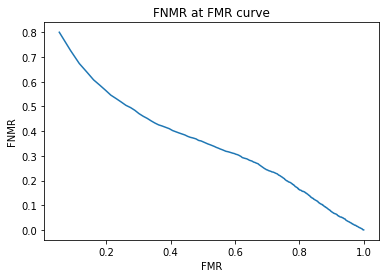

In [222]:
fmr_at_fnmr, eer, t_range, impostor_hist, pair_hist = get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'])

plt.plot(fmr_at_fnmr[:,0],fmr_at_fnmr[:,1])
plt.title("FNMR at FMR curve")
plt.xlabel("FMR")
plt.ylabel("FNMR")

In [212]:
fmr_at_fnmr, eer, t_range, impostor_hist, pair_hist = get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'])

Text(0, 0.5, 'FNMR')

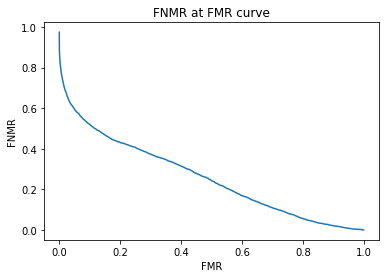

In [213]:
plt.plot(fmr_at_fnmr[:,0],fmr_at_fnmr[:,1])
plt.title("FNMR at FMR curve")
plt.xlabel("FMR")
plt.ylabel("FNMR")

Text(0, 0.5, 'FNMR')

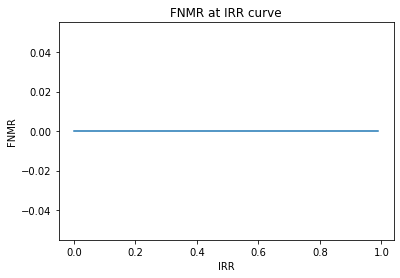

In [214]:
plt.plot(irr_fnmr[:,0],irr_fnmr[:,1])
plt.title("FNMR at IRR curve")
plt.xlabel("IRR")
plt.ylabel("FNMR")

Text(0, 0.5, 'Rate')

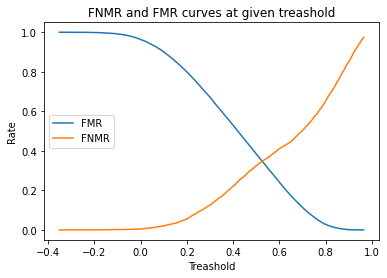

In [215]:
plt.plot(t_range, fmr_at_fnmr[:,0], label="FMR")
plt.plot(t_range, fmr_at_fnmr[:,1], label="FNMR")
plt.legend()
plt.title("FNMR and FMR curves at given treashold")
plt.xlabel("Treashold")
plt.ylabel("Rate")

Histogrmams


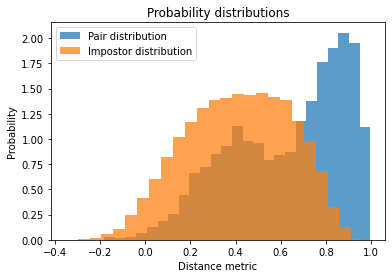

In [216]:
plt.hist(pair_hist[1][:-1], pair_hist[1], weights=pair_hist[0],alpha=0.73,label='Pair distribution')
plt.hist(impostor_hist[1][:-1], impostor_hist[1], weights=impostor_hist[0],alpha=0.73,label='Impostor distribution')
plt.legend()
plt.xlabel("Distance metric")
plt.ylabel("Probability")
plt.title("Probability distributions")
print("Histogrmams")